In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import readout
import inputs
import plot_utils as pu
from digest import conds, voltage_measures, get_digest_output
import isi_indexing as ii

import conf.isi5_mouse as cfg

import styling
from dish import dish

In [2]:
histograms = get_digest_output(cfg, 'histograms')
masked_histograms = get_digest_output(cfg, 'masked_histograms')
masked_histograms['pspike'] = histograms['pspike']
nspikes = get_digest_output(cfg, 'nspikes-neuronmean')

In [3]:
# Note: Demonstrator here is different from Fig 3+ demonstrator, since this one here is chosen exclusively for its similarity to culture.
demonstrator = dict(net=26, ipair=0, istim=0)

query = dict(**demonstrator, templ=0, isi=500, STD=1, TA=1)
index_N, index_t = ii.get_onset_ordering(cfg, histograms['pspike'], **query)
tmax = index_t.max() + 1
nspikes_time = dict(zip(conds, histograms['pspike'][ii.getindex(cfg, **query)][..., :tmax].sum(1)))

In [4]:
pmax = np.max([h.max() for h in nspikes_time.values()])
_pmax = np.amax([h for h in nspikes_time.values()], 0)
tmax = np.argmax(np.cumsum(_pmax > .01*pmax))
nspikes_time = {cond: h[:tmax] for cond, h in nspikes_time.items()}

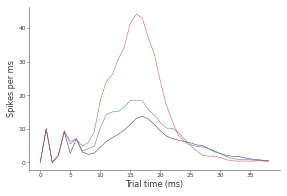

In [5]:
def panel_response(ax, response, dt, ylabel='Spikes per ms'):
    for cond in conds:
        ax.plot(np.arange(len(response[cond])) * dt/ms, response[cond], c=pu.colors[cond], label=cond)
    ax.set_xlabel('Trial time (ms)')
    ax.set_ylabel(ylabel)
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(4.5,3))
panel_response(ax, nspikes_time, cfg.params['dt'])

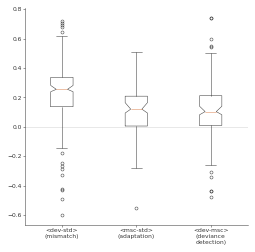

In [6]:
def panel_stats(ax):
    query = dict(isi=500, STD=1, TA=1)
    n = {cond: nspikes[cond][ii.getindex(cfg, **query)[:-1]].mean(-1) for cond in ('std', 'dev', 'msc')}  # mean over pulses
    def index(n0, n1):
        return ((n0-n1)/(n0+n1)).mean(0).flatten()  # mean over templates
    ax.axhline(0, color='lightgrey', zorder=0)
    # ax.yaxis.grid(True)
    ax.boxplot((
        index(n['dev'], n['std']),
        index(n['msc'], n['std']),
        index(n['dev'], n['msc']),
    ), notch=True, bootstrap=10000)
    ax.set_xticks(range(1,4), ('<dev-std>\n(mismatch)', '<msc-std>\n(adaptation)', '<dev-msc>\n(deviance\ndetection)'))
    # ax.set_ylabel('Index $\\in [-1,1]$')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(4,4))
panel_stats(ax)

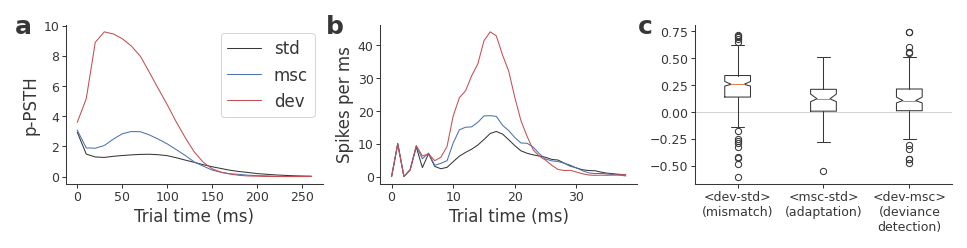

In [7]:
fig = plt.figure(figsize=(6.29, 1.5), dpi=150, layout='constrained')
gs = fig.add_gridspec(1, 3)

ax4 = fig.add_subplot(gs[0])
panel_response(ax4, dish, dish['dt'], ylabel='p-PSTH')
ax4.legend()

ax2 = fig.add_subplot(gs[1])
panel_response(ax2, nspikes_time, cfg.params['dt'])

ax3 = fig.add_subplot(gs[2])
panel_stats(ax3)

for x, a in zip((0, .33, .66), 'abc'):
    fig.text(x, 1, a, **styling.label_kwargs, va='top')

plt.savefig('paper-1/fig2.pdf')